## Exploring individual events ##

Looking at the meteorology which drives the extremes in demand net wind, for both the observed and the model time series.

E.g. 2010 for the obs

In [1]:
# Import local modules
import os
import sys
import glob

# Import external modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import cartopy.crs as ccrs
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import tqdm
from tqdm import tqdm

In [2]:
# Set up the global variables
saved_dir = "/home/users/benhutch/unseen_multi_year/dfs"
dfs_dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs"

# set up the fnames - daily wind power
daily_obs_wind_fname = (
    "United_Kingdom_wind_power_df_test_ons_ofs_1960_2018_NDJFM_obs.csv"
)
daily_model_wind_fname = "United_Kingdom_wind_power_df_test_ons_ofs_1960_2018_NDJFM.csv"

# set up the fnames - daily demand
daily_model_demand_fname = "model_demand_NDJFM_daily.csv"
daily_obs_demand_fname = "obs_wd_demand_1960_2019_United_Kingdom.csv"

In [3]:
# load the observed data
daily_obs_wind = pd.read_csv(os.path.join(saved_dir, daily_obs_wind_fname))
daily_obs_demand = pd.read_csv(os.path.join(dfs_dir, daily_obs_demand_fname))

In [4]:
daily_obs_wind.head()

,Unnamed: 0,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen
0,1960-11-01,11.325152,0.699079,0.826896,10.392515,12.201679
1,1960-11-02,14.248714,0.804985,0.874877,11.966914,12.909687
2,1960-11-03,10.112684,0.553986,0.661860,8.235563,9.766404
3,1960-11-04,8.534932,0.419052,0.496145,6.229633,7.321120
4,1960-11-05,7.439478,0.249140,0.326865,3.703711,4.823227


In [5]:
daily_obs_demand.head()

,Unnamed: 0,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960-11-01,9.970184,5.529816,0.0,39.190225
1,1960-11-02,8.484436,7.015564,0.0,40.300983
2,1960-11-03,6.850250,8.649750,0.0,41.522715
3,1960-11-04,7.034576,8.465424,0.0,41.384911
4,1960-11-05,7.439514,8.060486,0.0,41.082176


In [6]:
# join by using the "Unnamed: 0" column
obs_df = pd.merge(daily_obs_wind, daily_obs_demand, on="Unnamed: 0")

In [7]:
# set "Unnamed: 0" as datetime
obs_df["Unnamed: 0"] = pd.to_datetime(obs_df["Unnamed: 0"])

# set the datetime as the index
obs_df.set_index("Unnamed: 0", inplace=True)

# remove the name of the index
obs_df.index.name = None

In [8]:
obs_df.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
1960-11-01,11.325152,0.699079,0.826896,10.392515,12.201679,9.970184,5.529816,0.0,39.190225
1960-11-02,14.248714,0.804985,0.874877,11.966914,12.909687,8.484436,7.015564,0.0,40.300983
1960-11-03,10.112684,0.553986,0.661860,8.235563,9.766404,6.850250,8.649750,0.0,41.522715
1960-11-04,8.534932,0.419052,0.496145,6.229633,7.321120,7.034576,8.465424,0.0,41.384911
1960-11-05,7.439478,0.249140,0.326865,3.703711,4.823227,7.439514,8.060486,0.0,41.082176


In [9]:
# Calculate the demand net wind
obs_df["demand_net_wind"] = obs_df["United_Kingdom_demand"] - (
    obs_df["ons_gen"] + obs_df["ofs_gen"]
)

In [10]:
# make a copy of the obs_df
obs_df_copy = obs_df.copy()

# perform a rolling climatology
rolling_climatology = obs_df_copy.rolling(
    window="14D", min_periods=1, center=False
).mean()

# add a new column for the day of the year
rolling_climatology["day_of_year"] = rolling_climatology.index.dayofyear

# calculate the mean for each day of the year
climatology = rolling_climatology.groupby("day_of_year").mean()

In [11]:
# subset climatology to days of the year in NDJFM
climatology_ND = climatology.loc[(climatology.index >= 305)]
climatology_JFM = climatology.loc[(climatology.index <= 90)]

# concatenate the two dataframes
climatology_NDJFM = pd.concat([climatology_ND, climatology_JFM])

In [12]:
# add a new column for winter day of the year
# which is just the index of each row, e.g. 0, 1, 2, + 1
climatology_NDJFM["winter_day_of_year"] = np.arange(1, len(climatology_NDJFM) + 1)

In [13]:
# set day_of_year as a column
climatology_NDJFM.reset_index(inplace=True)

# set winter_day_of_year as the index
climatology_NDJFM.set_index("winter_day_of_year", inplace=True)

In [14]:
climatology_NDJFM.head()

,day_of_year,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,demand_net_wind
winter_day_of_year,,,,,,,,,,,
1,305,7.978300,0.348096,0.425224,5.174788,6.274610,9.159602,6.340743,0.0,39.796481,28.347083
2,306,8.011804,0.352310,0.429910,5.237441,6.343753,9.090415,6.409924,0.0,39.848202,28.267007
3,307,8.070306,0.356337,0.433614,5.297299,6.398413,8.999005,6.501335,0.0,39.916541,28.220829
4,308,8.041429,0.353470,0.430998,5.254692,6.359809,8.852899,6.647440,0.0,40.025771,28.411269
5,309,8.035100,0.353129,0.430748,5.249615,6.356116,8.719852,6.780487,0.0,40.125238,28.519506


<AxesSubplot:xlabel='winter_day_of_year'>

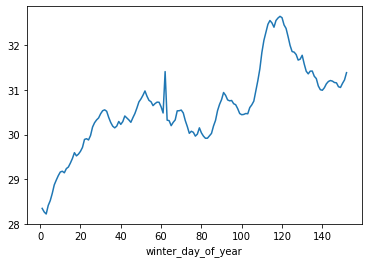

In [15]:
# plot the climatology for demand net wind
climatology_NDJFM["demand_net_wind"].plot()

In [16]:
# apply a 5 day rolling mean to the observed data
obs_df_smooth = obs_df.rolling(window="5D", min_periods=5, center=True).mean()

In [17]:
# subset obs_df_smooth to days of the year in NDJFM
obs_df_smooth_NDJFM_2011 = obs_df_smooth.loc[
    (obs_df_smooth.index >= "2010-11-01") & (obs_df_smooth.index <= "2011-03-31")
]

In [18]:
len(obs_df_smooth_NDJFM_2011.index)

151

In [19]:
len(climatology_NDJFM.index)

152

Text(0, 0.5, 'Demand Net Wind (GW)')

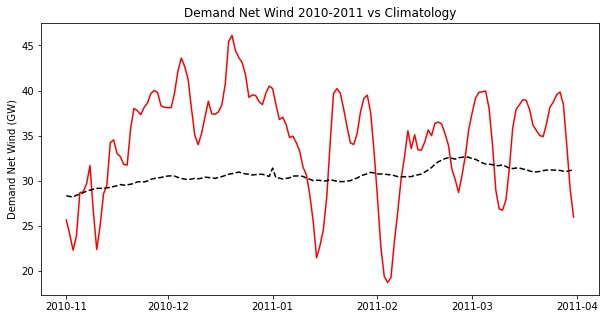

In [20]:
# Plot the demand net wind for 2010 relative to the climatology
# November 2010 -> March 2011
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the period of interest
plt.plot(
    obs_df_smooth_NDJFM_2011.index,
    obs_df_smooth_NDJFM_2011["demand_net_wind"],
    label="2010-2011",
    color="red",
)

# plot the climatology
plt.plot(
    obs_df_smooth_NDJFM_2011.index,
    climatology_NDJFM["demand_net_wind"][:-1],
    label="climatology",
    color="black",
    linestyle="--",
)

# set the title
plt.title("Demand Net Wind 2010-2011 vs Climatology")

# set the x-axis label
plt.ylabel("Demand Net Wind (GW)")

In [31]:
# write a function for plotting the full field MSLP data
# for a full period of interest e.g. November 2010 -> March 2011
def plot_mslp_anoms(
    start_date: str,
    end_date: str,
    title: str,
    variable: str = "msl",
    freq: str = "amon",
    lat_bounds: list = [30, 80],
    lon_bounds: list = [-90, 30],
    ERA5_regrid_path: str = "/gws/nopw/j04/canari/users/benhutch/ERA5/global_regrid_sel_region_psl.nc",
):
    """
    Grabs the MSLP anomalies for a given period of interest and plots them.

    Args:
        start_date (str): The start date of the period of interest.
        end_date (str): The end date of the period of interest.
        title (str): The title of the plot.
        variable (str): The variable of interest.
        freq (str): The frequency of the data.
        lat_bounds (list): The latitude bounds for the plot.
        lon_bounds (list): The longitude bounds for the plot.
        ERA5_regrid_path (str): The path to the regridded ERA5 data.

    Returns:
        None
    """

    # Load the observed data
    ds = xr.open_mfdataset(
        ERA5_regrid_path,
        chunks={"time": 10},
        combine="by_coords",
        parallel=False,
        engine="netcdf4",
        coords="minimal",
    )

    # If expver is present in the observations
    if "expver" in ds.coords:
        # Combine the first two expver variables
        ds = ds.sel(expver=1).combine_first(ds.sel(expver=5))

    # if the variable is not in the dataset
    if variable not in ds:
        # raise an error
        raise ValueError(f"{variable} not in dataset")

    # select the variable
    ds = ds[variable].sel(time=slice(start_date, end_date)).mean(dim="time")

    # subset to the region of interest
    ds = ds.sel(
        lat=slice(lat_bounds[0], lat_bounds[1]), lon=slice(lon_bounds[0], lon_bounds[1])
    )

    # extract the lons
    lons = ds["lon"].values
    lats = ds["lat"].values
    field = ds.values

    # set up the figure
    fig, ax = plt.subplots(
        figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree())
    )

    # define the contour levels
    clevs = np.linspace(field.min(), field.max(), 20)

    # print the shape of the inputs
    print(f"lons shape: {lons.shape}")
    print(f"lats shape: {lats.shape}")
    print(f"field shape: {field.shape}")
    print(f"clevs shape: {clevs.shape}")

    # Define the custom diverging colormap
    # cs = ["purple", "blue", "lightblue", "lightgreen", "lightyellow", "orange", "red", "darkred"]
    # cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

    cs = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]
    cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

    # plot the data
    mymap = ax.contourf(
        lons, lats, field, clevs, transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both"
    )

    # add coastlines
    ax.coastlines()

    # format the gridlines and labels
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size':7, 'color':'black'}
    gl.ylabels_right = False
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size':7, 'color':'black'}


    # add colorbar
    cbar = plt.colorbar(mymap, orientation='horizontal', shrink=0.7, pad=0.1)
    cbar.set_label('mean sea level pressure (hPa)', rotation=0, fontsize=10)
    cbar.ax.tick_params(labelsize=7, length=0)

    # add title
    ax.set_title(title, fontsize=12)
    
    # make plot look nice
    plt.tight_layout()

    # save figure to file
    # plt.savefig('../images/8_python_simple_map_plot_sst_anoms_300dpi.png',
    # format='png', dpi=300)
    
    # plt.close()

    return None

lons shape: (49,)
lats shape: (21,)
field shape: (21, 49)
clevs shape: (20,)


/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


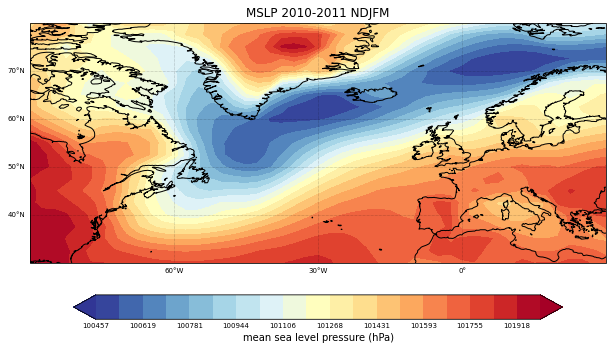

In [32]:
# test the function
plot_mslp_anoms(start_date="2010-11-01", end_date="2011-03-31", title="MSLP 2010-2011 NDJFM")